# Initial Preparation

In this section, I set up the environment by installing required libraries, mounting Google Drive, ad configuring the working directory to manage and access project files effectively.

To start, I installed and imported every necessary libraries.

In [ ]:
%pip install youtube-comment-downloader
%pip install langchain_community
%pip install replicate

In [ ]:
from google.colab import drive
import os

from youtube_comment_downloader import *
from tqdm.notebook import tqdm
import datetime
import pytz

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from langchain_community.llms import Replicate
from google.colab import userdata

Google Drive is then mounted to the Colab environment, and the working directory is changed to my preferred folder within my drive to access and save datasets scraped and cleaned.

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DataProject/SDI')

Mounted at /content/drive


# Web Scraping

In this section, I aim to build the raw dataset by web scraping where I collect and organize YouTube comments into a usable format for analysis.

`youtube_comment_downloader` library is used to scrape comments from Justin Sung's relevant video -- [**4 Reasons Hard Work DOES NOT Beat Talent**](https://www.youtube.com/watch?v=aRHTEhQp1g0) -- by its video URL. I choose to sort it by popularity so the "head" of the dataset can represent the most relevant and trustworthy comments, as they reflect broader viewer agreement or engagement from its number of likes.

In [ ]:
downloader = YoutubeCommentDownloader()
comments = downloader.get_comments_from_url("https://www.youtube.com/watch?v=aRHTEhQp1g0", sort_by=SORT_BY_POPULAR)

# youtube-comment-downloader returns a generator that produces one comment (dictionary type) at a time, so I collect them into a list first (tqdm for a convenient progress bar)
comments_list = list(tqdm(comments, desc="Downloading Comments"))

# Set timezone to Asia/Jakarta (WIB)
wib_tz = pytz.timezone("Asia/Jakarta")
now = datetime.datetime.now(wib_tz)

print(f"\nComments scraped on: {now.strftime('%A, %d %B %Y %H:%M:%S')}")


Comments scraped on: Sunday, 03 August 2025 13:46:44


Based on [DeepWiki](https://deepwiki.com/egbertbouman/youtube-comment-downloader/1.2-features), the comments gathered have the following features.
1. `cid`: Comment ID  
2. `text`: Comment text content  
3. `time`: Publication time as string  
4. `time_parsed`: Parsed timestamp (when available)  
5. `author`: Author display name  
6. `channel`: Author channel ID  
7. `votes`: Number of likes  
8. `replies`: Number of replies  
9. `photo`: Author profile photo URL  
10. `heart`: Whether the creator hearted the comment  
11. `reply`: Whether it's a reply to another comment  
12. `paid`: Text for paid comments (Super Chat)

Below is an example of a comment from the list.

In [ ]:
comments_list[0]

{'cid': 'UgwFnoEVROyPz3rdN_94AaABAg',
 'text': 'Join my Learning Drops weekly newsletter here: https://bit.ly/4c15rqY\nEvery week, I distil what really works for improving results, memory, depth of understanding, and knowledge application from over a decade of coaching into bite-sized emails.',
 'time': '1 year ago',
 'author': '@JustinSung',
 'channel': 'UC2Zs9v2hL2qZZ7vsAENsg4w',
 'votes': '7',
 'replies': '',
 'photo': 'https://yt3.ggpht.com/IDthoe4zGCdT94i4iyUQjR97Sz5woOyAQLuo9sOihhPYLL9TcUScEqOEZWfFdwcrLHVlDzBW=s88-c-k-c0x00ffffff-no-rj',
 'heart': False,
 'reply': False,
 'time_parsed': 1722667573.234489}

More than half of those features are irrelevant to my analysis. To avoid unnecessary complexity and maintain a focused dataset, I selected features which directly support the identification of viewpoints, patterns of engagement, and the structure of the discussion, which are central to my analysis. The selected features are `author`, `text`, `time`, `votes`, and `reply`.

When building the dataset, I also renamed the features to `username`, `comment/reply` (each text can be a comment or a reply to a comment), `time` (stays the same), `likes` (more general), and `isReply`. These names more clearly reflect their contents, making it easier to interpret each attribute's purpose during analysis.

In [ ]:
df = pd.DataFrame(comments_list)

df = df[['author', 'text', 'time', 'votes', 'reply']]
df.columns = ['username', 'comment/reply', 'time', 'likes', 'isReply']

print("First 5 comments of the raw dataset:")
display(df.head())

First 5 comments of the raw dataset:


,username,comment/reply,time,likes,isReply
0,@JustinSung,"Join my Learning Drops weekly newsletter here: https://bit.ly/4c15rqY\nEvery week, I distil what really works for improving results, memory, depth of understanding, and knowledge application from over a decade of coaching into bite-sized emails.",1 year ago,7,False
1,@vikshi,Hardwork beats talent when talent doesn't work hard.,1 year ago,2.1K,False
2,@julesinmed,"Personally, I think hard work should lead to smart work. We tend to associate the term hard work with concepts like long hours, lack of sleep and exhaustion, while it would be more useful if these circumstances were seen as a ''prompt'' to find a way to work smarter (simply to avoid being crushed by them, following natural evolution and self-preservation). Also, the process of simplification is itself ''hard work'', just not in the conventional, general view!",1 year ago (edited),1.3K,False
3,@alphaomega6023,4:21 1. Hard work has diminishing returns\r\n6:27 2. Effort is fuel\r\n10:29 3. Hard work is also about the type of work that you do\r\n12:22 Two things to do to solve this,1 year ago,372,False
4,@eagle772,"“Talent is just the natural ability for someone to intuitively use more optimal processes.” \n\nWow, that is some deep insight!\n\nIt basically means, you need to discover the optimal processes that will give you the desired results . And then train yourself on making them intuitive; second nature. \n\nThen keep upgrading them. So you are able to do more with less. \n\nThank you Justin! You have literally changed my life. \n\nThank you brother!",1 year ago,916,False


The raw dataset is saved for future reference.

In [ ]:
df.to_csv("raw_dataset.csv", index=False)

# Initial Exploration

In this section, I review the dataset's structure several data quality issues and formulate a plan to address them to prepare a cleaner and more reliable dataset for analysis.

In [ ]:
df = pd.read_csv("raw_dataset.csv")

In [ ]:
print(f"Dataset shape: {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset shape: 972 rows and 5 columns.


There are 972 comments in the raw dataset, each containing 5 insightful attributes, which are their username, comment/reply text, time, number of likes, and whether it is a reply.

In [ ]:
print("First 5 comments:")
display(df.head())

First 5 comments:


,username,comment/reply,time,likes,isReply
0,@JustinSung,"Join my Learning Drops weekly newsletter here: https://bit.ly/4c15rqY\nEvery week, I distil what really works for improving results, memory, depth of understanding, and knowledge application from over a decade of coaching into bite-sized emails.",1 year ago,7,False
1,@vikshi,Hardwork beats talent when talent doesn't work hard.,1 year ago,2.1K,False
2,@julesinmed,"Personally, I think hard work should lead to smart work. We tend to associate the term hard work with concepts like long hours, lack of sleep and exhaustion, while it would be more useful if these circumstances were seen as a ''prompt'' to find a way to work smarter (simply to avoid being crushed by them, following natural evolution and self-preservation). Also, the process of simplification is itself ''hard work'', just not in the conventional, general view!",1 year ago (edited),1.3K,False
3,@alphaomega6023,4:21 1. Hard work has diminishing returns\r\n6:27 2. Effort is fuel\r\n10:29 3. Hard work is also about the type of work that you do\r\n12:22 Two things to do to solve this,1 year ago,372,False
4,@eagle772,"“Talent is just the natural ability for someone to intuitively use more optimal processes.” \n\nWow, that is some deep insight!\n\nIt basically means, you need to discover the optimal processes that will give you the desired results . And then train yourself on making them intuitive; second nature. \n\nThen keep upgrading them. So you are able to do more with less. \n\nThank you Justin! You have literally changed my life. \n\nThank you brother!",1 year ago,916,False


The first comment is actually from the creator himself, @JustinSung, which makes me wonder whether he interacts with his audience as well. If he does, it might present a problem for my analysis. Since my goal is to analyze audience perspectives, **including the creator's own comment could introduce bias or skew the results because it might reflect an inherent confirmation of the video's message**, not an independent reaction like those from viewers. Therefore, identifying and filtering comments from @JustinSung is necessary to ensure the analysis reflects only the audience's viewpoints.

In [ ]:
author_comments = df[df['username'] == '@JustinSung']
print(f"Number of comments from @JustinSung: {len(author_comments)}")
print("First 6 comments from @JustinSung")
display(author_comments.head(6))

Number of comments from @JustinSung: 37
First 6 comments from @JustinSung


,username,comment/reply,time,likes,isReply
0,@JustinSung,"Join my Learning Drops weekly newsletter here: https://bit.ly/4c15rqY\nEvery week, I distil what really works for improving results, memory, depth of understanding, and knowledge application from over a decade of coaching into bite-sized emails.",1 year ago,7,False
27,@JustinSung,Succinctly put.,1 year ago,133,True
87,@JustinSung,I love it - totally agree.,1 year ago,113,True
112,@JustinSung,You absolutely nailed it.,1 year ago,49,True
136,@JustinSung,I wonder how many people completely skipped over this part of the video? I really think it's a pivotal life concept.,1 year ago,22,True
139,@JustinSung,"yep when you do the right thing, hard work is still an option that remains open for you. But without doing the right thing, hard work blocks you from learning the right thing.",1 year ago,103,True


There are 37 comments/replies from @JustinSung, some of which contributes to the debate of hardwork vs talent. To maintain analytical integrity and focus solely on external audience perspectives, I will drop all comments made by @JustinSung from the dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       972 non-null    object
 1   comment/reply  972 non-null    object
 2   time           972 non-null    object
 3   likes          972 non-null    object
 4   isReply        972 non-null    bool  
dtypes: bool(1), object(4)
memory usage: 31.5+ KB


All columns in the dataset have 972 non-null entires, which matches the total number of rows, indicating that there are **no missing values**.

However, **both the `time` and `likes` columns are stored as object types**, which makes them difficult to work with during analysis, as object types prevent direct sorting (especially sorting by chronological order) or numerical computation (especially aggregating by likes). Hence, they require additional preprocessing such as converting `time` as an ordinal data type and `likes` as integers.

In [ ]:
print("unique time:")
print(df['time'].unique().tolist())

unique time:
['1 year ago', '1 year ago (edited)', '10 months ago', '9 months ago', '8 months ago', '7 months ago', '6 months ago', '5 months ago', '1 month ago', '5 months ago (edited)', '3 months ago', '11 months ago', '2 days ago', '9 days ago', '11 days ago', '1 month ago (edited)', '4 months ago', '4 months ago (edited)', '2 months ago', '2 weeks ago', '17 hours ago', '6 months ago (edited)', '3 weeks ago', '4 weeks ago']


An additional problem in the `time` column is that **some entries include the string '(edited)' which introduces inconsistency in format**. To address this, I will remove the substring '(edited)' from all `time` entries.

Also, **the timestamps in the dataset vary in both granularity and scale, with some indicate hours, other days, and some even weeks** yet all refer to comments posted within the past month. Keeping them as-is adds unnecessary complexity and does not significantly improve the analysis. To streamline the data and focus on broader temporal trends rather than fine-grained distinctions, I will unify all entries labeled within one month ('1 hour ago', '9 days ago', '4 week ago', etc.) into a single category: 'this month'. This simplification allows for more meaningful insights and clearer visualization without sacrificing analytical value.

In [ ]:
print("Unique likes:")
print(df['likes'].unique().tolist())

Unique likes:
['7', '2.1K', '1.3K', '372', '916', '622', '35', '36', '47', '159', '489', '213', '73', '71', '72', '173', '15', '32', '5', '250', '169', '88', '9', '16', '24', '21', '133', '12', '23', '3', '25', '1', '11', '0', '2', '86', '113', '14', '4', '49', '8', '6', '17', '22', '26', '103', '52', '27', '10', '28', '18', '31', '80', '48', '141', '30', '13', '38', '29', '42', '19']


Another problem in the `likes` column is **the use of the letter 'K' to denote thousands**, which prevents the values from being treated as numeric types. This formatting inconsistency makes it difficult to perform quantitative analysis, such as aggregating likes. To resolve this, I will convert all such entries by replacing the 'K' with multiplying it by a thousand, then typecasting it as an integer, finally standardizing the column for numerical operations. Approximating each likes with the letter 'K' is okay in this analysis because the level of precision is sufficient for understanding general engagement trends and does not significantly affect the overall analysis.

In [ ]:
duplicates = df[df.duplicated(subset=['username', 'comment/reply'], keep=False)]

print(f"Number of duplicate comments (based on username and comment/reply): {len(duplicates)}")
display(duplicates.sort_values(by=['username', 'comment/reply']))

Number of duplicate comments (based on username and comment/reply): 2


,username,comment/reply,time,likes,isReply
83,@josephwillyyose3443,Talent is everything with hard work. Hard work is nothing without talent.,6 months ago,0,True
359,@josephwillyyose3443,Talent is everything with hard work. Hard work is nothing without talent.,6 months ago,2,False


I filter duplicates by `username` and `comment/reply` because based on my observation, **users sometimes post identical comments multiple times**. One case would be when they reply to different comments with the same exact message they want to share. Another one would be where they want to gain as much attention as possible or emphasize a certain message. This leads to duplicate content under the same name. By identifying duplicates based solely on the `comment/reply` and `username`, I focus on removing redundant content regardless of when or where it was posted.

We can see one duplicate pair appearing which shows one of his post is a reply to another comment, but the other is his comment to the video (as can be seen from the `isReply` column). This supports my earlier observation that I mentioned and ultimately leads me to drop Joseph's duplicate comment with the least likes, as keeping the version with higher engagement better represents audience reception while reducing noise in the dataset.

# Preprocessing

In this section, I refine the dataset by addressing data quality issues identified during the initial exploration.

First, I drop every comments from the author (@JustinSung).

In [ ]:
df = df[df['username'] != '@JustinSung'].copy()

print(f"Number of comments after removing author's comments: {len(df)}")
print("First 5 comments:")
display(df.head())

Number of comments after removing author's comments: 935
First 5 comments:


,username,comment/reply,time,likes,isReply
1,@vikshi,Hardwork beats talent when talent doesn't work hard.,1 year ago,2.1K,False
2,@julesinmed,"Personally, I think hard work should lead to smart work. We tend to associate the term hard work with concepts like long hours, lack of sleep and exhaustion, while it would be more useful if these circumstances were seen as a ''prompt'' to find a way to work smarter (simply to avoid being crushed by them, following natural evolution and self-preservation). Also, the process of simplification is itself ''hard work'', just not in the conventional, general view!",1 year ago (edited),1.3K,False
3,@alphaomega6023,4:21 1. Hard work has diminishing returns\r\n6:27 2. Effort is fuel\r\n10:29 3. Hard work is also about the type of work that you do\r\n12:22 Two things to do to solve this,1 year ago,372,False
4,@eagle772,"“Talent is just the natural ability for someone to intuitively use more optimal processes.” \n\nWow, that is some deep insight!\n\nIt basically means, you need to discover the optimal processes that will give you the desired results . And then train yourself on making them intuitive; second nature. \n\nThen keep upgrading them. So you are able to do more with less. \n\nThank you Justin! You have literally changed my life. \n\nThank you brother!",1 year ago,916,False
5,@zirak21mistry,"""You can work hard and still do poorly"". Can't agree more. All my engineering years, I worked fairly hard, put in multiple extra hours, and attended extra classes. Even after all this extra effort, I managed to get slightly about average grades whereas my few talented peers worked half as hard but produced double the results with exceptional grades. That was the moment when I realised that it is more to it than just hard work.\n\nEveryone always says to work harder and harder. They say that you have not yet achieved success because you have not worked hard enough. \n\nI feel it is only so much hard work you can do because you have limited time and energy and it is only a matter of time before your genetics give up and you get burnt out (probably multiple times) and give up eventually.\n\nFinally someone can understand my point of view. Glad I found you and your channel.",1 year ago,622,False


Second, I remove every substring of '(edited)' from the `time` column

In [ ]:
df['time'] = df['time'].str.replace(' \(edited\)', '', regex=True)

print("Unique time:")
print(df['time'].unique().tolist())

Unique time:
['1 year ago', '10 months ago', '9 months ago', '8 months ago', '7 months ago', '6 months ago', '5 months ago', '1 month ago', '3 months ago', '11 months ago', '2 days ago', '9 days ago', '11 days ago', '4 months ago', '2 months ago', '2 weeks ago', '17 hours ago', '3 weeks ago', '4 weeks ago']


Third, I unify every time value that indicates a recent post into a single label, 'this month'.

In [ ]:
def unify_recent_times(time_str):
    if 'weeks ago' in time_str or 'days ago' in time_str or 'hours ago' in time_str:
         return 'this month'
    return time_str

df['time'] = df['time'].apply(unify_recent_times)

print("Unique time:")
print(df['time'].unique().tolist())

Unique time:
['1 year ago', '10 months ago', '9 months ago', '8 months ago', '7 months ago', '6 months ago', '5 months ago', '1 month ago', '3 months ago', '11 months ago', 'this month', '4 months ago', '2 months ago']


Fourth, I convert the `time` column into an ordered categorical variable based on a chronological list, allowing for proper sorting and time-based analysis.

In [ ]:
time_order = ['1 year ago', '11 months ago', '10 months ago', '9 months ago', '8 months ago', '7 months ago', '6 months ago', '5 months ago', '4 months ago', '3 months ago', '2 months ago', '1 month ago', 'this month']

df['time'] = pd.Categorical(df['time'], categories=time_order, ordered=True)

print("Ordered time categories:")
print(df['time'].cat.categories.tolist())

Ordered time categories:
['1 year ago', '11 months ago', '10 months ago', '9 months ago', '8 months ago', '7 months ago', '6 months ago', '5 months ago', '4 months ago', '3 months ago', '2 months ago', '1 month ago', 'this month']


Fifth, I standardize the `likes` values by converting shorthand notation of 'K' into their full numeric form.

In [ ]:
def convert_likes_to_int(likes_str):
    if isinstance(likes_str, str):
        likes_str = likes_str.replace('K', 'e3')
        return int(float(likes_str))
    return int(likes_str)

df['likes'] = df['likes'].apply(convert_likes_to_int)

print("Unique likes sorted by descending order:")
print(sorted(df['likes'].unique().tolist(), reverse=True))

Unique likes sorted by descending order:
[2100, 1300, 916, 622, 489, 372, 250, 213, 173, 169, 159, 141, 88, 86, 80, 73, 72, 71, 48, 47, 42, 38, 36, 35, 32, 30, 29, 28, 26, 25, 24, 23, 21, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


Sixth, I manually drop a specific comment that is a duplicate by its content and username.

In [ ]:
comment_to_drop = df[(df['username'] == '@josephwillyyose3443') & (df['likes'] == 0) & (df['comment/reply'] == 'Talent is everything with hard work. Hard work is nothing without talent.')]

df = df.drop(comment_to_drop.index)

duplicates = df[df.duplicated(subset=['username', 'comment/reply'], keep=False)]

print(f"Number of duplicate comments (based on username and comment/reply): {len(duplicates)}")

Number of duplicate comments (based on username and comment/reply): 0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 934 entries, 1 to 971
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   username       934 non-null    object  
 1   comment/reply  934 non-null    object  
 2   time           934 non-null    category
 3   likes          934 non-null    int64   
 4   isReply        934 non-null    bool    
dtypes: bool(1), category(1), int64(1), object(2)
memory usage: 31.7+ KB


We can see that `date` is now an ordered category type, and `likes` is an integer.

In [ ]:
df.describe(include='int').T

,count,mean,std,min,25%,50%,75%,max
likes,934.0,9.56424,91.981181,0.0,0.0,0.0,1.0,2100.0


As a final check, I inspected the `likes` column for any anomalies or implausible values. No issues were found.

# Model Setup

In this section, I retrieve and configure the API token to authenticate requests to Replicate and choose a designated model perfect for this analysis.

I retrieve the API token from my Colab's user data and setting it as an environment variable so it can be used by the Replicate API.

In [ ]:
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

I choose to use IBM Granite (`granite-3.3-8b-instruct`) because it is well-suited for two key tasks in this analysis: stance classification and summarization.

The model has been fine-tuned with instruction-following data and **optimized for tasks like text classification**, which is central to identifying whether a comment supports hard work, favors talent, stays neutral, or is irrelevant. Its architecture allows it to understand nuanced language and subtle argumentation often present in real-world comments.

Additionally, Granite is **designed to perform well in summarization tasks**, making it highly effective for deriving key insights from categorized comments and summarizing multiple sides of the debate.

Together, these strengths make IBM Granite an ideal choice for conducting a rigorous, structured exploration of the hard work versus talent debate.

Source: https://docs.api.nvidia.com/nim/reference/ibm-granite-3_3-8b-instruct

In [ ]:
model = "ibm-granite/granite-3.3-8b-instruct"

# Feature Engineering

In this section, I create a new column called `stance` which represent each comment's position in the hard work versus talent debate.

Each comment will be reviewed and classified by the IBM Granite model into one of four categories:
* 'Pro', comments that support the idea that hard work can overcome talent.
* 'Contra', comments that argue talent outweights hard work.
* 'Neutral', comments that acknowledge both sides without a strong stance.
* 'Irrelevant', comments that do not meaningfully contribute to the debate, such as general video feedback or unrelated remarks.

Including the **'Neutral'** category allows me to capture comments that acknowledge both hard work and talent without taking a strong stance, which adds depth to the analysis by revealing more nuanced or integrative perspectives. It provides a fuller, more balanced understanding of the overall sentiment surrounding the debate.

On the other hand, **'Irrelevant'** comments will be dropped later to help ensure the analysis remains focused, accurate, and grounded in content that directly engages with the core debate.

The model is fine tuned for the classification task based on the recommendation from "Data Classification and Summarization Using IBM Granite" module:
- `top_k = 1`: Forces the model to always pick the most probable next word, making its output highly focused and deterministic.  
- `top_p = 0.5`: Narrows the token pool to only high-probability options, making outputs more concise and relevant.  
- `max_tokens = 3`: Strictly limits the response length, ensuring the output remains extremely brief and to the point.  
- `min_tokens = 1`: Guarantees that at least one token is generated, preventing empty outputs while maintaining conciseness.  
- `random_seed = 42` **(my pick)**: Makes the results consistent when running the same input again.  
- `repetition_penalty = 1.5`: Strongly discourages repetition, encouraging more varied and compact wording.  
- `stopping_criteria = "length"`: Ends generation once the token limit is reached, precisely controlling response size.  
- `stopping_sequence = " "`: Encourages the model to stop at natural word boundaries, improving clarity even in short outputs.


In [ ]:
classification_parameters = {
    "top_k": 1,
    "top_p": 0.5,
    "max_tokens": 3,
    "min_tokens": 1,
    "random_seed": 42,
    "repetition_penalty": 1.5,
    "stopping_criteria": "length",
    "stopping_sequence": " "
}

Now, I initialize the Replicate object with the IBM Granite model and my classification task tuned parameters using my API token to classify each comment's stance.

In [ ]:
output = Replicate(
    model=model,
    replicate_api_token=api_token,
    model_kwargs=classification_parameters
)

I then prompt the model focusing on three key aspects.
* **Context**: I define the task's domain clearly where the model roleplay as an expert to analyze YouTube comments that discuss the theme "Hard work beats talent." This narrows the model's scope and attention to relevant expressions, attitudes, or stances related to the debate.
* **Clarity**: I give a precise instruction to output only one of four possible labels ('Pro', 'Contra', 'Neutral', or 'Irrelevant'), and explicitly prohibits any additional text. It eliminates ambiguity and ensures consistent, minimal responses ideal for structured classification tasks.
* **Examples**: I provide short realistic examples for each classification type. These examples demonstrate how to interpret different opinions and help guide the model toward accurate categorization, especially in nuanced or ambiguous cases.

In [ ]:
classification_prompt = """
You are an expert sentiment classifier specializing in online comments about the relationship between hard work and talent.
Your task is to strictly categorize YouTube comments based on their stance toward the statement: "Hard work beats talent."
Analyze the following comment and provide ONLY ONE WORD as its classification.
Choose from these four categories: "Pro", "Contra", "Neutral", or "Irrelevant".
Do NOT provide any explanation, reasoning, or additional text before or after the classification word.

Here are examples to guide your classification:

Comment: "Hard work always pays off, talent means nothing without effort."
Classification: Pro

Comment: "Some people are just born with it, no matter how hard I try I can't keep up."
Classification: Contra

Comment: "Both hard work and talent are important for success."
Classification: Neutral

Comment: "Great video! Thanks for sharing."
Classification: Irrelevant

Comment:
{comment}

Classification:"""

Time to classify each comment's stance.

In [ ]:
# Create a new column for the stance
df['stance'] = None

# Iterate through each comment and classify it
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Classifying comments"):
    comment = row['comment/reply']
    prompt = classification_prompt.format(comment=comment)

    # Get the model's prediction
    prediction = output.invoke(prompt)

    # Clean up the prediction to ensure it's just one word (handle potential newline characters or extra spaces)
    cleaned_prediction = prediction.strip().split('\n')[0].split(' ')[0]

    # Further validation to ensure the output is one of the expected categories
    valid_categories = ["Pro", "Contra", "Neutral", "Irrelevant"]
    if cleaned_prediction in valid_categories:
        df.loc[index, 'stance'] = cleaned_prediction
    else:
        print(f"Model returned unexpected classification '{prediction}' for comment at index {index}")
        df.loc[index, 'stance'] = prediction # Store raw prediction

print("First 5 comments with new column 'stance':")
display(df.head())

Classifying comments:   0%|          | 0/934 [00:00<?, ?it/s]

First 5 comments with new column 'stance':


,username,comment/reply,time,likes,isReply,stance
1,@vikshi,Hardwork beats talent when talent doesn't work hard.,1 year ago,2100,False,Pro
2,@julesinmed,"Personally, I think hard work should lead to smart work. We tend to associate the term hard work with concepts like long hours, lack of sleep and exhaustion, while it would be more useful if these circumstances were seen as a ''prompt'' to find a way to work smarter (simply to avoid being crushed by them, following natural evolution and self-preservation). Also, the process of simplification is itself ''hard work'', just not in the conventional, general view!",1 year ago,1300,False,Pro
3,@alphaomega6023,4:21 1. Hard work has diminishing returns\r\n6:27 2. Effort is fuel\r\n10:29 3. Hard work is also about the type of work that you do\r\n12:22 Two things to do to solve this,1 year ago,372,False,Neutral
4,@eagle772,"“Talent is just the natural ability for someone to intuitively use more optimal processes.” \n\nWow, that is some deep insight!\n\nIt basically means, you need to discover the optimal processes that will give you the desired results . And then train yourself on making them intuitive; second nature. \n\nThen keep upgrading them. So you are able to do more with less. \n\nThank you Justin! You have literally changed my life. \n\nThank you brother!",1 year ago,916,False,Irrelevant
5,@zirak21mistry,"""You can work hard and still do poorly"". Can't agree more. All my engineering years, I worked fairly hard, put in multiple extra hours, and attended extra classes. Even after all this extra effort, I managed to get slightly about average grades whereas my few talented peers worked half as hard but produced double the results with exceptional grades. That was the moment when I realised that it is more to it than just hard work.\n\nEveryone always says to work harder and harder. They say that you have not yet achieved success because you have not worked hard enough. \n\nI feel it is only so much hard work you can do because you have limited time and energy and it is only a matter of time before your genetics give up and you get burnt out (probably multiple times) and give up eventually.\n\nFinally someone can understand my point of view. Glad I found you and your channel.",1 year ago,622,False,Contra


Looking at the first five comments, it seems to classify the comments quite well.
* The **first comment** is correctly classified as 'Pro' because it clearly supports the value of hard work over talent.
* The **second comment** is also accurately labeled 'Pro', as it reframes hard work into a smarter approach without undermining its importance.
* The **third comment** is rightly marked 'Neutral' since it discusses various perspectives on hard work without taking a clear stance for or against it.
* The **fourth comment** labeled as 'Irrelevant' is appropriate because its focus is on personal gratitude and life transformation, not on taking a clear stance in the hard work vs talent debate.
* The **fifth comment** is also appropriate as 'Contra' because it argues that talent outperforms hard work based on his experience.

Before immediately dropping the 'Irrelevant' categories, I want to check its composition inside the dataset to see the significance of dropping it.

In [ ]:
# Define a color map for each stance with my chosen shades
color_map = {
    'Pro': '#87CEFA',     # Light Sky Blue
    'Contra': '#FA8072',  # Salmon
    'Neutral': '#90EE90', # Light Green
    'Irrelevant': '#D3D3D3' # Light Grey
}

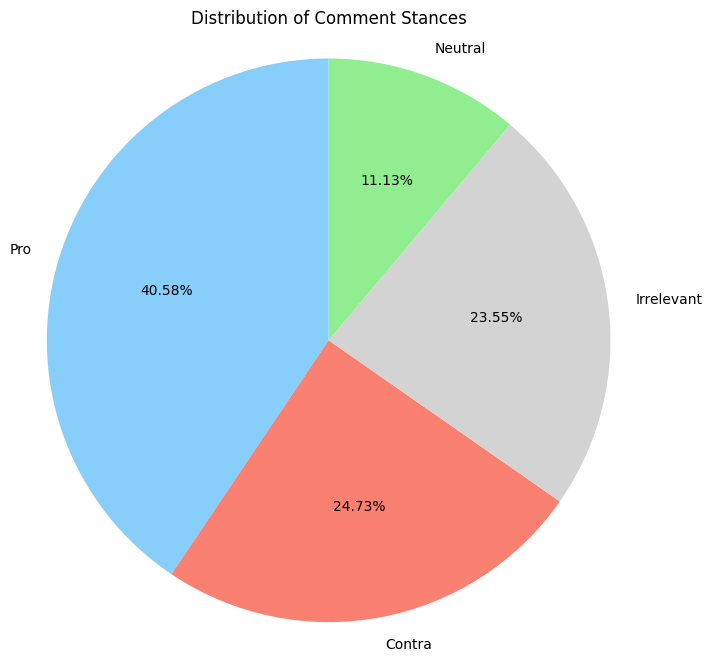

In [ ]:
# Count the occurrences of each stance category
stance_counts = df['stance'].value_counts()

# Create a list of colors in the order of the stance_counts index
colors = [color_map[stance] for stance in stance_counts.index]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(stance_counts, labels=stance_counts.index, autopct='%1.2f%%', startangle=90, colors=colors)
plt.title('Distribution of Comment Stances')
plt.axis('equal')
plt.show()

'Irrelevant' comments only make up about 23.55% of the data, hence removing them will surely sharpen the insight derived from my future analysis without compromising dataset size.

In [ ]:
df = df[df['stance'] != 'Irrelevant'].copy()

print(f"Number of comments after removing irrelevant comments: {len(df)}")
display(df.head(10))

Number of comments after removing irrelevant comments: 714


,username,comment/reply,time,likes,isReply,stance
1,@vikshi,Hardwork beats talent when talent doesn't work hard.,1 year ago,2100,False,Pro
2,@julesinmed,"Personally, I think hard work should lead to smart work. We tend to associate the term hard work with concepts like long hours, lack of sleep and exhaustion, while it would be more useful if these circumstances were seen as a ''prompt'' to find a way to work smarter (simply to avoid being crushed by them, following natural evolution and self-preservation). Also, the process of simplification is itself ''hard work'', just not in the conventional, general view!",1 year ago,1300,False,Pro
3,@alphaomega6023,4:21 1. Hard work has diminishing returns\r\n6:27 2. Effort is fuel\r\n10:29 3. Hard work is also about the type of work that you do\r\n12:22 Two things to do to solve this,1 year ago,372,False,Neutral
5,@zirak21mistry,"""You can work hard and still do poorly"". Can't agree more. All my engineering years, I worked fairly hard, put in multiple extra hours, and attended extra classes. Even after all this extra effort, I managed to get slightly about average grades whereas my few talented peers worked half as hard but produced double the results with exceptional grades. That was the moment when I realised that it is more to it than just hard work.\n\nEveryone always says to work harder and harder. They say that you have not yet achieved success because you have not worked hard enough. \n\nI feel it is only so much hard work you can do because you have limited time and energy and it is only a matter of time before your genetics give up and you get burnt out (probably multiple times) and give up eventually.\n\nFinally someone can understand my point of view. Glad I found you and your channel.",1 year ago,622,False,Contra
6,@Darknight526,12:06\nSuccess = Hard work x Talent x Processes \nTalent is the natural ability to intuitively use more optimal processes.\nThanks Justin!,1 year ago,35,False,Pro
7,@PixelatedApollo1,"It’s also enormously BASED when someone who struggles more at doing something, (or has less talent) but works hard anyways. They can see peers easily progressing faster than them, but yet they struggle on and achieve greatness within their own time. I respect people who accomplish something very challenging, even if it was easy for other people.",1 year ago,36,False,Pro
8,@debeatz3381,"can't beat a guy with both hard work and talent. Met a guy like that....dude was a machine, my man is gonna be a good doctor after 3 years. Wishing him all the best 👍",1 year ago,47,False,Pro
9,@shenghongzhong,"""Taking action is rarely about changing your action immediately. Most of time, especially for things that are difficult and complex, taking action means making decision to learn what action you should take""",1 year ago,159,False,Neutral
10,@eagle772,“Working hard never had anything to do with it. It’s not about how hard you work on something. It’s about doing the right thing.”,1 year ago,489,False,Contra
11,@IamKudos,"Really love this video. I think the reason people love to say ""Hard work beats talent"" is because they see talent as this mysterious gift that people have been privileged with by genetics or something. People don't want to flip a stone to check and see what really is talent. It's just better cognitive recognition and higher-order learning that people do accidentally for one thing. And because they didn't realize that they were doing that, they cant seem to apply that for others. Hence that becomes their ""talent"". And people like things explained in simplified terms. So they don't even want to wrap their head around what talent really is, or if they can DEVELOP or LEARN to be smart, to be talented. Deploying your brain is seeming to be harder to people than just passively putting in a grind of 10 hours of hard work. When you're active and aware of the processes you're using to improve yourself, you will achieve something even better than talent.",1 year ago,213,

The final cleaned and complete dataset is saved for future reference.

In [ ]:
df.to_csv("clean_dataset.csv", index=False)

# Exploratory Data Analysis (EDA)

In this section, I perform exploratory data analysis to examine the distribution, engagement, temporal trends, and key discussion themes of the comments, providing both quantitative and visual insights to support my stance summarization.

In [ ]:
# df = pd.read_csv("clean_dataset.csv")

I want to firstly check the distribution of comment stances after dropping the "Irrelevant" ones. It helps me understand how the remaining comments are actually divided -- whether they lean more toward supporting, opposing, or staying neutral -- so I can draw more credible conclusion.

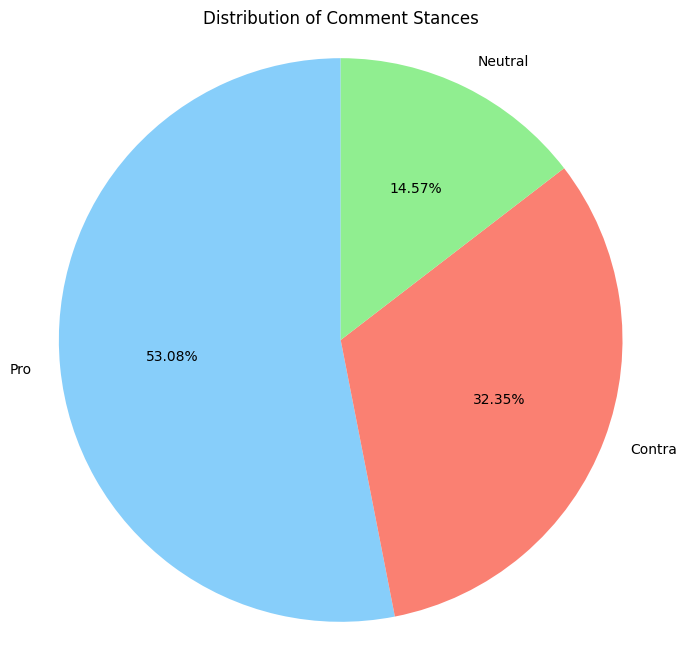

In [ ]:
# Count the occurrences of each stance category
stance_counts = df['stance'].value_counts()

# Create a list of colors in the order of the stance_counts index
colors = [color_map[stance] for stance in stance_counts.index]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(stance_counts, labels=stance_counts.index, autopct='%1.2f%%', startangle=90, colors=colors)
plt.title('Distribution of Comment Stances')
plt.axis('equal')
plt.show()

The pie chart reveals that the majority of comments (52.08%) express a 'Pro' stance, about 32.35% are 'Contra', and 14.56% are 'Neutral'. This distribution reflects that the dominant opinion in the comment section leans toward valuing effort over innate ability. Hence, it should be acknowledged that **the 'Pro' stance will naturally be represented more prominently in the summarization.**

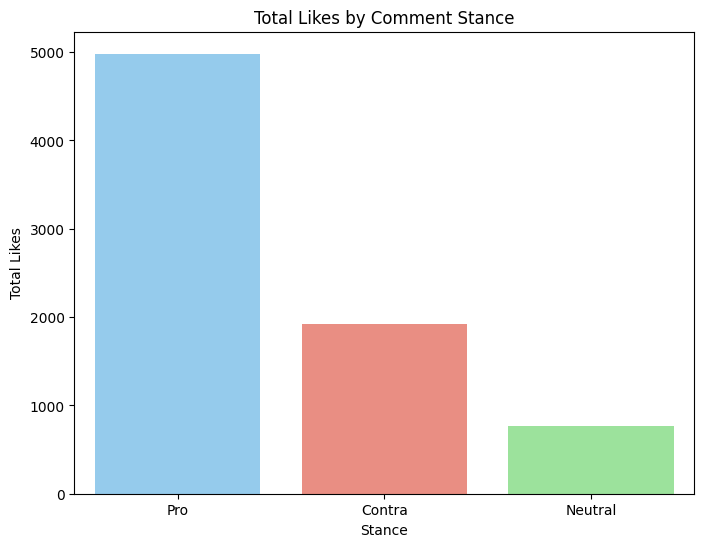

In [ ]:
# Group by stance and sum the likes
likes_by_stance = df.groupby('stance')['likes'].sum().reset_index()

# Sort by likes in descending order for better visualization
likes_by_stance = likes_by_stance.sort_values(by='likes', ascending=False)

# Create a list of colors in the order of the likes_by_stance index
colors = [color_map[stance] for stance in likes_by_stance['stance']]

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='stance', y='likes', data=likes_by_stance, palette=colors, hue='stance', legend=False)
plt.title('Total Likes by Comment Stance')
plt.xlabel('Stance')
plt.ylabel('Total Likes')
plt.show()

Once again, the chart confirms that the 'Pro' stance not only dominates in quantity but also receives significantly more audience approval, as reflected by the total number of likes. This reinforces the earlier point that **any summarization will naturally be skewed toward the 'Pro' perpective, not by bias in the analysis, but due to the moderately strong imbalance in both representation and engagement.**

Next, I will use a line chart to see how the number of comments in each stance evolved overtime. This format makes it easier to detect temporal patterns, such as spikes or long-term trends, and to compare stances side by side in a clean, continuous format.

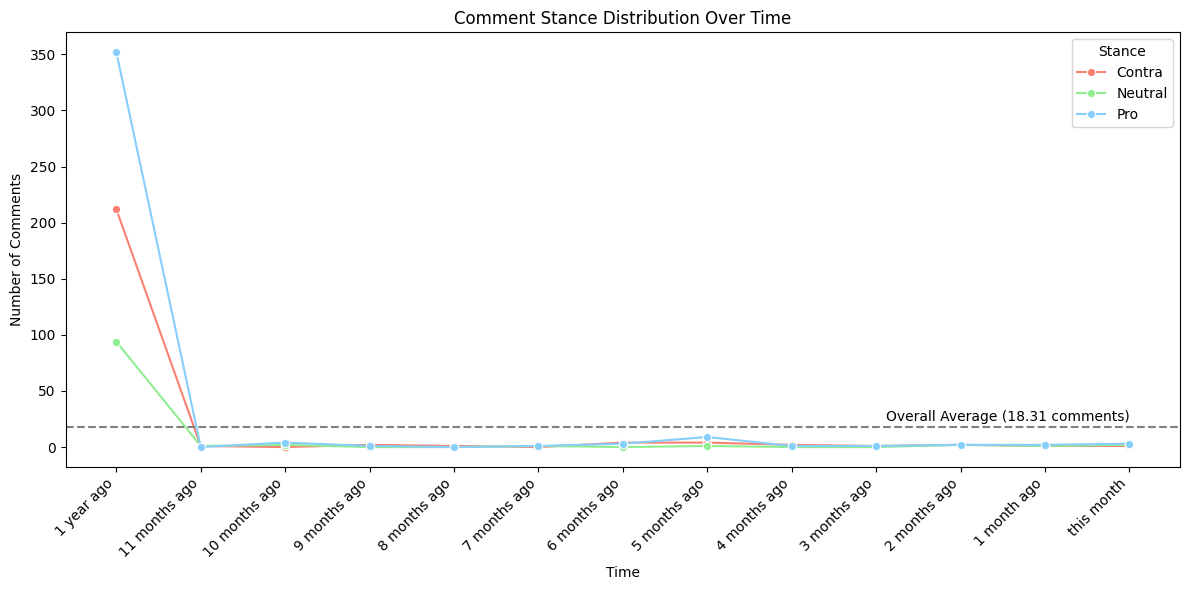

In [ ]:
# Group by time and stance, then count the occurrences
stance_over_time = df.groupby(['time', 'stance'], observed=False).size().reset_index(name='count')

# Calculate the overall average comment count
overall_average_count = stance_over_time['count'].mean()

# Create the line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=stance_over_time, x='time', y='count', hue='stance', marker='o', palette=color_map)
plt.axhline(y=overall_average_count, color='grey', linestyle='--')
plt.text(
    stance_over_time['time'].iloc[-1],
    overall_average_count + 2,
    f'Overall Average ({overall_average_count:.2f} comments)',
    verticalalignment='bottom',
    horizontalalignment='right',
    color='black'
)
plt.title('Comment Stance Distribution Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stance')
plt.tight_layout()
plt.show()

From the chart, it's clear that almost all comments were posted around the time the video was released (1 year ago). In the following months, the number of new comments dropped sharply and remained near zero. This suggests that user engagement was heavily concentrated at the time of release and has not sustained over time.

As a result, **any stance summarization or sentiment analysis done on this analysis will primarily reflect the opinions of viewers from one year ago, not the current audience**. Therefore, the conclusions drawn may be indicative of opinions in the past year, 2024.

Lastly, I visualize the comments using a word cloud to quickly identify the most frequently mentioned concepts, which helps validate whether user discussions are truly centered around talent and hard work which is the core focus of my analysis.

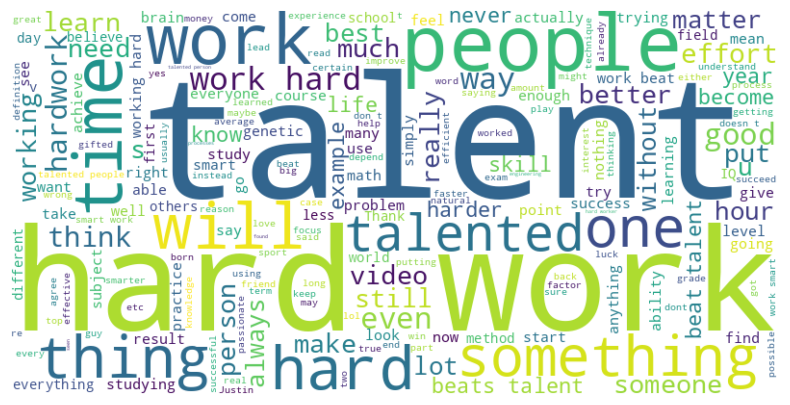

In [ ]:
# Combine all comments into a single string
all_comments = " ".join(df['comment/reply'].dropna().tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The word cloud effectively visualizes the central focus of the discussion, aligning perfectly with my analysis on the debate between talent and hard work. The most prominent words, such as 'talent', 'hard', 'work', 'people', and 'time' highlight the key themes users repeatedly mention. Their frequency confirms that **viewers are deeply engaged with the video's main question, making my stance classification and summarization highly relevant**. Additionally, the appearance of phrases like 'beats talent', 'practice', and 'effort' supports my interpretation that **users are contrasting natural ability with perseverance and consistent effort**.

# Stance Summarization

In this section, I configure the designated model with optimized summarization parameters, initialize it with my API token, and prompt it to generate clear, context-aware, and well-structured bullet-point summaries of the key arguments for each stance based on the classified comments.

The model is fine-tuned for the summarization task based on the recommendation from the "Data Classification and Summarization Using IBM Granite" module:
- `top_k = 10`: Allows the model to choose from the top 10 most likely tokens, introducing slight variation while maintaining coherence. This is useful for generating more natural and fluid summaries.
- `top_p = 0.9`: Retains only the top 90% of cumulative probability mass for token selection, balancing creativity with relevance to produce richer, yet focused summaries.
- `max_tokens = 500`: Expands the output length limit to accommodate detailed summaries with up to five fully developed bullet points, each explaining a recurring argument with moderate depth and clarity.  
- `min_tokens = 200`: Ensures that the summary includes substantial content, preventing the model from producing overly short or incomplete outputs while still allowing for variation in length.
- `random_seed = 42` **(my pick)**: Ensures consistent outputs across runs for the same input, useful for evaluation and reproducibility.  
- `repetition_penalty = 1.5`: Discourages redundant phrasing, improving the quality of summarization by making it more compact and diverse.  
- `stopping_criteria = "length"`: Automatically ends generation when the token limit is reached.
- `stopping_sequence = " "`: Encourages output to stop at natural word boundaries, leading to clearer and more readable sentence fragments.

In [ ]:
summarization_parameters = {
    "top_k": 10,
    "top_p": 0.9,
    "max_tokens": 500,
    "min_tokens": 200,
    "random_seed": 42,
    "repetition_penalty": 1.5,
    "stopping_criteria": "length",
    "stopping_sequence": " "
}

Now, I initialize the Replicate object with the IBM Granite model and my summarization task tuned parameters using my API token to summarize each stance from the comments.

In [ ]:
output = Replicate(
    model=model,
    replicate_api_token=api_token,
    model_kwargs=summarization_parameters
)

I then prompt the model focusing on three key aspects.
* **Clarity**: I ensure that each bullet point is written in a way that is easy to understand, avoiding both vague generalizations and overly technical language. The instructions specify a balance between being informative without becoming dense so the summary remains accessible and academically suitable.
* **Context**: I provide the stance category and debate topic to ground the model's output in the appropriate thematic frame. This helps the model generate points that are not only relevant but also reflective of recurring ideas within a particular argumentative position (Pro, Contra, or Neutral).
* **Format**: I define a strict, consistent structure using bullet points with bolded titles, a limit of five items, and no concluding paragraph. This format encourages thematic grouping of ideas and avoids unnecessary filler or narrative drift.


In [ ]:
def summarize_stance_comments(df, stance, debate_topic, output):
    stance_comments_df = df[df['stance'] == stance]
    comments_text = "\n---\n".join(stance_comments_df['comment/reply'].dropna().tolist())

    summary_prompt = f"""
    Summarize the following user comments, which fall into the "{stance}" category, using no more than five bullet points.

    Strictly follow these instructions:
    - Use bullet points only (-).
    - Limit your output to a maximum of five bullet points.
    - Do not include a concluding paragraph.
    - Each bullet point must summarize a recurring argument, belief, or example found in the comments.
    - Explain each point with moderate detail, enough to be informative and clear, but not overly technical or deeply analytical.
    - Avoid surface-level phrasing (e.g., "X is good") and overly complex arguments; aim for clarity and balance.
    - Maintain a neutral, evidence-aware tone suitable for academic presentation.

    The purpose of this summary is to investigate differing public opinions about whether *{debate_topic}*, using real-world responses.

    Each bullet point should begin with a short, descriptive title in bold (without numbering), followed by a colon and a detailed explanation.

    Here are the comments classified as {stance}:
    {comments_text}

    Summary:
    """

    return output.invoke(summary_prompt)

Finally, I can extract a summary of the key points associated with each stance.

In [ ]:
pro_summary = summarize_stance_comments(df, "Pro", "hard work beats talent", output)
print(pro_summary)

- **Hard Work as a Precursor to Smart Work**: Many commenters emphasize that hard work, when combined with the right methods or "processes," leads to smart work. This suggests that hard work lays the foundation for developing efficient strategies and techniques, which in turn enhances productivity and results.

- **Talent as Intuitive Optimal Processes**: Talent is described as an innate ability to instinctively use optimal processes. This implies that talent is not merely a static attribute but a dynamic capacity to apply effective strategies efficiently.

- **Hard Work as a Necessity for Success**: Numerous comments underscore the necessity of hard work for achieving success, regardless of initial talent levels. The consensus is that without hard work, talent alone is insufficient for reaching one's full potential.

- **Examples of Hard Work Overcoming Talent Without Effort**: Several personal anecdotes illustrate individuals who, through dedicated hard work, surpassed those with per

In [ ]:
contra_summary = summarize_stance_comments(df, "Contra", "hard work beats talent", output)
print(contra_summary)

- **Innate Limitations**: Many users highlight that individuals have inherent limitations, such as genetics or physical attributes, which cannot be overcome through hard work alone. For example, someone naturally taller and more athletically gifted in basketball like Michael Jordan or Ronaldo might inherently surpass someone who works extremely hard but lacks those physical attributes.

- **Talent as a Head Start**: Talent is often depicted as a significant advantage or "head start" that cannot be entirely caught up by hard work. Users suggest that talented individuals can excel in their fields with less effort compared to those who must work harder to achieve similar results.

- **Burnout and Diminishing Returns**: Some users argue that excessive hard work can lead to burnout, where the individual's energy and capacity diminish over time, regardless of their initial talent or potential. This suggests that while talent might give someone an initial edge, hard work without talent can le

In [ ]:
neutral_summary = summarize_stance_comments(df, "Neutral", "hard work beats talent", output)
print(neutral_summary)

- **Diminishing Returns of Hard Work**: Some commenters argue that the effectiveness of hard work decreases over time without proper strategy or optimization.
- **Quality of Effort**: Effort, or hard work, is emphasized to be about doing the right kind of work, not just putting in more hours.
- **Talent and Hard Work Synergy**: Many acknowledge that both talent and hard work are crucial; talent can make hard work more efficient, while hard work can help talented individuals reach their full potential.
- **Smart Work vs. Hard Work**: There's a recurring theme that 'smart work'—working efficiently and strategically—is more impactful than mere 'hard work' or mindless effort.
- **Environmental and Personal Factors**: Comments highlight the importance of upbringing, experience, consistency, and personal interest in shaping success, suggesting that talent is often a product of nurture rather than nature alone.
